In [1]:
%matplotlib notebook
import matplotlib
import numpy as np
from matplotlib import pyplot as plt

# Simple example implementations of Automatic Differentiation

**By Steve Marschner for Cornell CS6630, Fall 2022**

Automatic differentiation is an important tool in scientific computing, machine learning, and computer graphics.  It is a simple technique that works well to compute derivatives of nearly any function you can write a program to evaluate.  I want to build really simple, but working, model implementations of a couple basic autodiff methods, to show you how they work and to demonstrate how simple they are at their core, even if the details can get pretty involved in practice.

If you are looking at the static HTML version of this document on the course website, you can download the [live notebook](Autodiff.ipynb) to play with yourself.  Installing [Anaconda](https://www.anaconda.com/products/distribution) is an easy way to set up an appropriate Jupyter/Python environment.

## Forward mode
The simplest type of autodiff is known as forward mode, and we'll start with the simplest case, where we have a function of one variable that we want to differentiate--so every variable in the program is either a constant or something that depends on that one independent variable.

The idea is to think of the program that computes the function as a sequence of simple elementary operations, and to augment every operation so that it computes the derivative of its result from its inputs and their derivatives.  I'm going to do this by defining a class `var` that contains two numbers: a value and the derivative of that value with respect to the (single) independent variable.  It implements all the standard arithmetic operations, and in each case it uses the chain rule to compute the derivative of the new object it returns.

In Python this is going to produce computations that do a ton of extra heap allocation, which is not efficient, so it's really just a toy demonstration.  I'm not sure how to make it efficient in Python without doing source-to-source translation, but in C++ with expression templates it's possible to make a similar approach produce efficient code.

In [2]:
class var:
    
    # variables have a value and a derivative.
    # constants (constructed with single argument) have zero derivative.
    def __init__(self, v, d=0):
        self.v = v
        self.d = d
        
    # arithmetic ops propagate derivatives.  Cooler implementation could treat numeric types as constants.
    def __add__(l, r):
        return var(l.v + r.v, l.d + r.d)
    def __sub__(l, r):
        return var(l.v - r.v, l.d - r.d)
    def __mul__(l, r):
        return var(l.v * r.v, l.v * r.d + l.d * r.v)
    def __truediv__(l, r):
        return var(l.v / r.v, (l.d * r.v - l.v * r.d) / (r.v * r.v))
        
    # special functions have to be called as methods
    def sqrt(self):
        return var(np.sqrt(self.v), self.d / (2 * np.sqrt(self.v)))
    
    def __repr__(self):
        return f'(v={self.v},d={self.d})'

That's pretty simple.  Let me try it on a simple example:
$$f(x) = \frac{x}{\sqrt{1 + x}}.$$
The derivative, according to my scratch paper, ought to be 
$$f'(x) = \frac{x + 2}{2(1+x)^{3/2}}.$$
To evaluate the function and its derivative using my autodiff framework, I just have to compute the function using values of my `var` class rather than regular numbers.

In [3]:
# evaluate function using our differentiating type
def f(x):
    return x / (var(1)+x).sqrt()
# evaluate the derivative using a regular numerical type
def df(x):
    return (x + 2) / (2 * (1 + x)**(3/2))
def print_result(var):
    fv = f(var)
    d = df(var.v)
    print(f"val: {fv.v}, deriv: {fv.d}, ref_deriv: {d}, " +
          f"rel_err {(d - fv.d)/abs(d)}" if abs(d) > 1e-6 else f"err {d - fv.d}")
# a variable with derivative 1 is the independent variable; with derivative 0 is a constant
print_result(var(0, 1))
print_result(var(1, 1))
print_result(var(1.3, 1))
print_result(var(2, 1))

val: 0.0, deriv: 1.0, ref_deriv: 1.0, rel_err 0.0
val: 0.7071067811865475, deriv: 0.5303300858899106, ref_deriv: 0.5303300858899106, rel_err 0.0
val: 0.8571946154145232, deriv: 0.47303381787089066, ref_deriv: 0.4730338178708907, rel_err 1.1735133754519212e-16
val: 1.1547005383792517, deriv: 0.3849001794597505, ref_deriv: 0.3849001794597505, rel_err 0.0


Well that's good, the derivatives in the variables match the derivatives computed separately, with errors at most around the machine precision.  A more general way to check our results is with finite differences; here is a function that can do that:

In [4]:
def check_deriv(f, *args):
    """check the first derivative against a finite difference"""
    h = 1e-8
    # create constant values with the values of the arguments
    args0 = (var(v.v) for v in args)
    # create constant values offset according to the arguments' derivatives
    args1 = (var(v.v + h * v.d) for v in args)
    # do automatic differentiation (evlauate function for the variables)
    v = f(*args)
    # use finite differences (evaluate function for the constants and look at difference)
    d = (f(*args1).v - f(*args0).v) / h
    print(f'autodiff: {v}, fd: {d}, ' +
          (f"rel_err: {(d-v.d)/np.abs(v.d)}" if v.d > 1e-6 else f"err: {d-v.d}"))

In [5]:
# Now try it on a collection of examples.  Note that even though the functions take multiple
# arguments, there is still only one independent variable (which all arguments depend on)
check_deriv(lambda x,y : x + y, var(1,2), var(3,4))
check_deriv(lambda x,y : x - y, var(1,2), var(3,4))
check_deriv(lambda x,y : x * y, var(1,2), var(3,4))
check_deriv(lambda x,y : x / y, var(1,2), var(3,4))
check_deriv(lambda x,y : x * y + y * x, var(1,2), var(3,4))
check_deriv(lambda x,y : x / y + y / x, var(1,2), var(3,4))
check_deriv(lambda x,y : (x + y).sqrt(), var(1,2), var(3,4))

autodiff: (v=4,d=6), fd: 6.000000052353016, rel_err: 8.725502690746604e-09
autodiff: (v=-2,d=-2), fd: -1.999999987845058, err: 1.21549419418443e-08
autodiff: (v=3,d=10), fd: 10.000000116860974, rel_err: 1.1686097423080355e-08
autodiff: (v=0.3333333333333333,d=0.2222222222222222), fd: 0.22222222395562596, rel_err: 7.800316892403458e-09
autodiff: (v=6,d=20), fd: 20.00000023372195, rel_err: 1.1686097423080355e-08
autodiff: (v=3.3333333333333335,d=-1.7777777777777777), fd: -1.7777777916450077, err: -1.3867230030939481e-08
autodiff: (v=2.0,d=1.5), fd: 1.4999999908837935, rel_err: -6.07747097092215e-09


That is encouraging; the errors are on the order of the square root of the machine precision (we are using double precision here) which is about the best we can hope for from a finite difference derivative.

## Forward mode, multidimensional range
Without fundamentally changing anything, we can upgrade the forward mode autodiff variable so that it supports functions $f : \mathbb{R} \rightarrow \mathbb{R}^n$. The idea is to make a datatype that is like a NumPy array but which knows the derivative of all its components with respect to a single independent variable, and define arithmetic operations that operate on this datatype and compute the derivatives along with the values.  For elementary operations it's simple to compute the derivatives of the result from the derivatives of the operands using familiar formulas from calculus.  The matrix multiply derivative looks just like a regular product rule because it's just a sum of products.

In [6]:
class var:
    
    # variables have a value and a derivative.
    # Value and derivative can be an arrays of matching sizes.
    def __init__(self, v, d=None):
        self.v = v
        self.d = np.zeros_like(v) if d is None else d
        
    # arithmetic ops propagate derivatives.
    def __add__(l, r):
        return var(l.v + r.v, l.d + r.d)
    def __sub__(l, r):
        return var(l.v - r.v, l.d - r.d)
    def __mul__(l, r):
        return var(l.v * r.v, l.v * r.d + l.d * r.v)
    def __truediv__(l, r):
        return var(l.v / r.v, (l.d * r.v - l.v * r.d) / (r.v * r.v))
    
    # dot product actually looks just like the multiplication operation
    def __matmul__(l,r):
        return var(l.v @ r.v, l.d @ r.v + l.v @ r.d)
    
    @staticmethod
    def concatenate(varlist):
        return var(np.concatenate([x.v for x in varlist]), np.concatenate([x.d for x in varlist]))
    
    # special functions have to be called as methods
    def sqrt(self):
        return var(np.sqrt(self.v), self.d / (2 * np.sqrt(self.v)))
    
    def __repr__(self):
        return f'(v={self.v},d={self.d})'

Let's try it out computing the derivative of the length of a vector, first doing it all with scalars...

In [7]:
def length(x, y):
    return (x * x + y * y).sqrt()

In [8]:
# vector (2,2) changing in the direction (1,1)/sqrt(2) (should be 1)
check_deriv(length, var(2, np.sqrt(0.5)), var(2, np.sqrt(0.5)))
# vector (2,2) changing in the direction (1,-1)/sqrt(2) (should be 0)
check_deriv(length, var(2, np.sqrt(0.5)), var(2, -np.sqrt(0.5)))

autodiff: (v=2.8284271247461903,d=1.0), fd: 0.999999949513608, rel_err: -5.048639195592841e-08
autodiff: (v=2.8284271247461903,d=0.0), fd: 0.0, err: 0.0


...and trying the same thing with a vector operand

In [9]:
# First verifying that derivatives of dot products seem to work
check_deriv(lambda x,y: x @ y, 
           var(np.array([1,2,3]), np.array([0,1,0])), 
           var(np.array([2,4,3]), np.array([0,0,1]))
          )
check_deriv(lambda x,y: x @ y, 
           var(np.array([1,2,3]), np.array([0,1,0])), 
           var(np.array([2,4,3]), np.array([0,1,0]))
          )
check_deriv(lambda x,y: x @ y, 
           var(np.array([1,2,3]), np.array([5,3,6])), 
           var(np.array([2,4,3]), np.array([2,7,4]))
          )

autodiff: (v=19,d=7), fd: 6.999999868639861, rel_err: -1.876573410949537e-08
autodiff: (v=19,d=6), fd: 5.99999978589949, rel_err: -3.568341829425966e-08
autodiff: (v=19,d=68), fd: 68.00000065254608, rel_err: 9.596265847315354e-09


In [10]:
def length2(x):
    return (x @ x).sqrt()

In [11]:
# vector (2,2) changing in the direction (1,1)/sqrt(2) (should be 1)
check_deriv(length2, var(np.array([2,2]), np.array([1,1]) / np.sqrt(2)))
# vector (2,2) changing in the direction (1,-1)/sqrt(2) (should be 0)
check_deriv(length2, var(np.array([2,2]), np.array([1,-1]) / np.sqrt(2)))

autodiff: (v=2.8284271247461903,d=0.9999999999999999), fd: 0.999999949513608, rel_err: -5.0486391844906115e-08
autodiff: (v=2.8284271247461903,d=0.0), fd: 0.0, err: 0.0


Let's try this on a little more of an application: computing the tangent vector of a parametric curve.  Here's one called the Folium of Descartes:
$$
x(t) = \frac{3at}{1+t^3} \quad y(t) = \frac{3at^2}{1+t^3}
$$

In [12]:
a = 1
def folium(t):
    return var.concatenate([
        var(np.array([3*a])) * t / (var(1) + t*t*t),
        var(np.array([3*a])) * t * t / (var(1) + t*t*t)
    ])

<IPython.core.display.Javascript object>


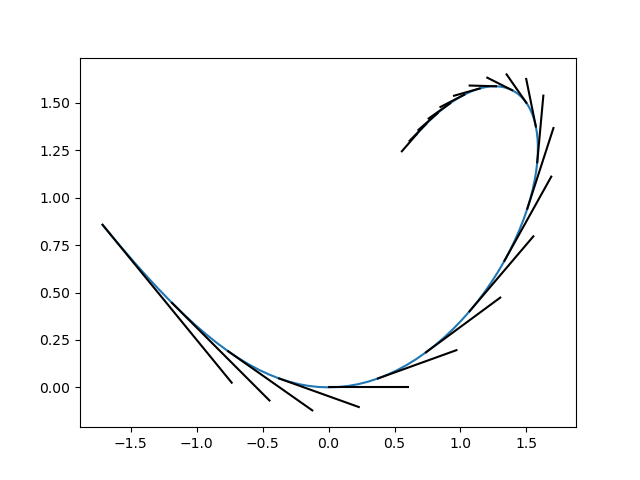

In [13]:
plt.figure()
pts = [folium(var(t,1)) for t in np.linspace(-0.5,2,101)]
plt.plot([p.v[0] for p in pts], [p.v[1] for p in pts])
plt.plot(
    [[p.v[0] for p in pts[::5]],[p.v[0] + 0.2 * p.d[0] for p in pts[::5]]],
    [[p.v[1] for p in pts[::5]],[p.v[1] + 0.2 * p.d[1] for p in pts[::5]]],
    'k'
);

That all worked well. 

# Reverse mode

One big problem with forward mode autodiff comes up if we have many independent variables.  Differentiating with respect to multiple independent variables is easy, but it involves essentially performing $n$ separate derivative computations, each of which costs as much as the first one, to compute the derivative (known as the gradient in this context) of a function $f : \mathbb{R}^n \rightarrow \mathbb{R}$.

There is a second way to do automatic differentiation, which takes exactly the same idea but computes derivatives from the output towards the input.

In [14]:
class bvar:
    # a variable has a value and an adjoint derivative.
    # The adjoint derivative is initially not defined.
    # The variable can depend on some other variables, and this is recorded
    #   by a list of arguments, each with the derivative of this variable 
    #   with respect to that argument.  Constants or independent variables
    #   have empty argument lists.
    def __init__(self, v, args = []):
        self.v = v
        self.args = args
        self.d = np.zeros_like(self.v)
        
    # arithmetic ops that propagate derivatives
    def __add__(l, r):
        return bvar(l.v + r.v, [(l, 1), (r, 1)])
    def __sub__(l, r):
        return bvar(l.v - r.v, [(l, 1), (r, -1)])
    def __mul__(l, r):
        return bvar(l.v * r.v, [(l, r.v), (r, l.v)])
    def __truediv__(l, r):
        return bvar(l.v / r.v, [(l, 1. / r.v), (r, -l.v / (r.v * r.v))])
    
    # dot product
    def __matmul__(l,r):
        return bvar(l.v @ r.v, [(l, r.v), (r, l.v)])
    
    # some special functions to be called as methods
    def sqrt(self):
        return bvar(np.sqrt(self.v), [(self, 1. / (2 * np.sqrt(self.v)))])
    
    def backprop(self, d):
        self.d += d
        for a, da in self.args:
            a.backprop(d*da)
    
    def __repr__(self):
        return f'(v={self.v},args={[(repr(arg), deriv) for (arg, deriv) in self.args]},d={self.d})'

In [15]:
def f1(x,y):
    return (x*x + y*y).sqrt()
def f2(x):
    return (x@x).sqrt()
def f3(x,y):
    return x*x/y + y/x*y

In [17]:
# with separate scalar variables (args is a list of values)
def test2(f, args):
    # backward mode: create independent var for each argument
    v = [bvar(arg) for arg in args]
    f(*v).backprop(1.)
    # derivatives are found sitting in the independent vars
    print(tuple(x.d for x in v))
    # forward mode for comparison: repeat for each independent variable
    # derivatives are found in the variables resulting from the computation
    print(tuple(
        f(*[var(arg, 1 if i==j else 0) for j, arg in enumerate(args)]).d
        for i in range(len(args))
    ))
test2(f1, [1.,2.])
test2(f3, [1.,2.])

(array(0.4472136), array(0.89442719))
(0.4472135954999579, 0.8944271909999159)
(array(-3.), array(3.75))
(-3.0, 3.75)


In [18]:
# with single vector variable (arg is an numpy array)
def testv(f, arg):
    n = len(arg)
    # backward mode: create a vector-valued independent variable
    v = bvar(arg)
    f(v).backprop(1.)
    # derivatives are found in the components of that variable's derivative
    print(v.d)
    # forward mode: repeat n times, each time setting one component of the input derivative to 1
    print([f(var(arg, np.eye(n)[i])).d for i in range(n)])
testv(f2, np.array([1., 2.]))
testv(f2, np.array([1., 2., -2., 3.]))

[0.4472136  0.89442719]
[0.4472135954999579, 0.8944271909999159]
[ 0.23570226  0.47140452 -0.47140452  0.70710678]
[0.23570226039551587, 0.47140452079103173, -0.47140452079103173, 0.7071067811865476]


...so that works, with code that looks remarkably like the code used in forward mode.  The difference is the intermediate objects persist until the reverse pass.